In [1]:
import os

import polars as pl
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from lib import to_latex, shapiro_wilk, mann_whitney

dataset_url = "https://github.com/dracor-org/einakter/releases/download/v1.5.0/einakter-v1.5.0.json"  # For printing warning message -- we don't access the network from this notebook

sns.set_theme(font_scale=1.00, rc={"figure.figsize": (7, 4), "figure.autolayout": True})

# Constants
confidence_level = 0.95
dracor_blue = "#1f2448"
dpi = 300


# The dataset is expected to be located at dataset_path.
# Nix will automatically create a symlink to the dataset in the working directory.
dataset_path = "data/einakter.json"
if not os.path.isfile(dataset_path):
    print(f"Dataset not found at {dataset_path}")
    print(
        f"Nix (https://nixos.org/) is recommended for reproducibility. It will automatically download the dataset for you."
    )
    print(
        f"Alternatively, download the dataset manually and place it at {dataset_path}"
    )
    print(f"Using curl:")
    print(f"  $ curl -L '{dataset_url}' -o {dataset_path}")

    raise Exception(f"Dataset not found at {dataset_path}")


einakter = pl.read_json(dataset_path)

In [2]:
# Read GerDraCor data
gerdracor = (
    pl.read_json("data/gerdracor.json")
    .select(
        "id",
        acts_n="numOfActs",
        scenes_n="numOfSegments",
        characters_n="numOfSpeakers",
        year_norm="yearNormalized",
    )
    .filter(
        # Filter to Einakter DB time period
        ((1740 <= pl.col("year_norm")) & (pl.col("year_norm") <= 1850))
        & ((2 <= pl.col("acts_n")) & (pl.col("acts_n") <= 5))
    )
)

# Combine the two datasets
einakter_and_gerdracor = pl.concat(
    [
        gerdracor.with_columns(Dataset=pl.lit("GerDraCor")),
        einakter.select(
            "id",
            acts_n=pl.lit(1),
            # Adjust column names
            scenes_n="numberOfScenes",
            characters_n="numberOfCharacters",
            year_norm="normalizedYear",
            # Add dataset column
            Dataset=pl.lit("Einakter Database"),
        ),
    ],
    how="vertical_relaxed",
)

## Q1 Subtitle categorisation

Which dramatic category do the one-act plays of the period under investigation belong to?

In [3]:
import re


# Aggregate and count the most common subtitles
def extract_category(subtitle: str) -> str:
    cat_patterns = {
        "Drama": "(^|\W)Dramas?($|\s)",
        "Lustspiel": "(Lusts?piel|(K|C)om(ö|oe)die)",  # Lustspiel, Lustpiel, Komoedie, Komödie, Comödie etc.
        "Nachspiel": "Nachspiel",
        "Posse": "Posse",
        "Schauspiel": "Schauspiel",
        "Schwank": "Schwank",
        "Trauerspiel": "(Trauerspiel|Tragödie)",
        "Vorspiel": "Vorspiel",
    }
    for cat, pattern in cat_patterns.items():
        if re.search(pattern, subtitle, re.IGNORECASE):
            return cat
    return None


subtitles = einakter.with_columns(
    # map_elements is a lot slower than native expressions, but more legible
    category=pl.col("subtitle").map_elements(extract_category)
)


subtitles_agg = (
    subtitles.select(pl.col("category").value_counts())
    .unnest("category")
    # Add percentages
    .with_columns(
        percent=pl.col("count") / pl.col("count").sum() * 100,
        ci=pl.col("count")
        .map_elements(
            lambda k: stats.binomtest(k, subtitles.height).proportion_ci(
                confidence_level, method="exact"  # Use Clopper-Pearson method
            ),
            return_dtype=pl.List(pl.Float64),
        )
        .list.eval(pl.element() * 100),
    )
    .sort(pl.col("category").is_null(), "count", descending=[False, True])
)

# Subtitle mapping
subtitle_mapping = {
    "Drama": "",
    "Lustspiel": "Comedy",
    "Nachspiel": "Postlude",
    "Posse": "Farce",
    "Schauspiel": "",
    "Schwank": "",
    "Trauerspiel": "Tragedy",
    "Vorspiel": "Prelude",
}

to_latex(
    subtitles_agg.select(
        pl.col("category").alias("Category"),
        pl.col("category").replace(subtitle_mapping).alias(""),
        pl.col("count").alias("n"),
        pl.col("percent").alias("Percent"),
        pl.col("ci"),
    ),
    caption="Distribution of categories in the dataset with binomial confidence intervals.",
    label="tab:categories",
    na_rep="Other",
)

Saved to latex/categories.tex


## Q2 Number of scenes
Is there a difference in the *number of scenes per act* between German one-act plays and other German plays of the same period?

In [4]:
# Prepare dataframe for Q2 analysis
einakter_and_gerdracor_q2 = (
    einakter_and_gerdracor.drop_nulls("scenes_n")
    .with_columns(
        # Calculate the number of scenes per act
        scenes_per_act=(pl.col("scenes_n") / pl.col("acts_n"))
    )
    .filter(
        # Exclude some plays due to encoding idiosyncrasies
        # "Das Haus der Temperamente" https://dracor.org/id/ger000341
        # "Zu ebener Erde und erster Stock oder Die Launen des Glückes" https://dracor.org/id/ger000028
        (pl.col("id").is_in(["ger000341", "ger000028"]).not_())
    )
)

In [5]:
# Check scenes_n for normality

(
    einakter_and_gerdracor.group_by("Dataset").map_groups(
        lambda df: shapiro_wilk(df["scenes_n"].drop_nulls()) and df
    )
)

Shapiro-Wilk Test: W=0.991869876974901, p=4.5303368222386643e-10
The data is not normally distributed.
Shapiro-Wilk Test: W=0.39158322647778987, p=3.8658727204157985e-29
The data is not normally distributed.


id,acts_n,scenes_n,characters_n,year_norm,Dataset
str,i64,i64,i64,i64,str
"""ein000001""",1,22,6,1842,"""Einakter Datab…"
"""ein000002""",1,17,7,1818,"""Einakter Datab…"
"""ein000003""",1,6,2,1821,"""Einakter Datab…"
"""ein000004""",1,14,5,1821,"""Einakter Datab…"
"""ein000005""",1,12,5,1819,"""Einakter Datab…"
…,…,…,…,…,…
"""ger000295""",4,39,26,1828,"""GerDraCor"""
"""ger000607""",3,24,6,1836,"""GerDraCor"""
"""ger000505""",2,9,7,1835,"""GerDraCor"""


In [6]:
# A version of the dataset that also includes GerDraCor 2--5 acts_n as acts_n=99
einakter_and_gerdracor_q2_with_99 = pl.concat(
    [
        einakter_and_gerdracor_q2,
        # Duplicate as acts_n=99
        einakter_and_gerdracor_q2.filter(pl.col("Dataset") == "GerDraCor").with_columns(
            acts_n=pl.lit(99)
        ),
    ],
    how="vertical_relaxed",
)

scenes_per_act_agg = (
    einakter_and_gerdracor_q2_with_99.group_by("acts_n", "Dataset")
    .agg(
        pl.len().alias("n"),
        pl.mean("scenes_per_act").name.suffix("_mean"),
        # Calculate bootstrapped confidence intervals
        ci=pl.col("scenes_per_act").map_elements(
            lambda x: stats.bootstrap(
                (x,),
                np.mean,
                confidence_level=confidence_level,
                n_resamples=10_000,
                method="BCa",
                random_state=42,  # For reproducibility
            ).confidence_interval,
        ),
    )
    .select("Dataset", "acts_n", "n", "scenes_per_act_mean", "ci")
    .sort("acts_n")
)
scenes_per_act_agg

Dataset,acts_n,n,scenes_per_act_mean,ci
str,i64,u32,f64,list[f64]
"""Einakter Datab…",1,2306,14.200781,"[13.9549, 14.466175]"
"""GerDraCor""",2,31,13.758065,"[11.532258, 16.040565]"
"""GerDraCor""",3,69,10.318841,"[9.062802, 11.62359]"
"""GerDraCor""",4,28,9.044643,"[7.383929, 10.732143]"
"""GerDraCor""",5,140,6.97,"[6.34, 7.668571]"
"""GerDraCor""",99,268,8.834142,"[8.219247, 9.500333]"


In [7]:
to_latex(
    scenes_per_act_agg.select(
        "Dataset",
        pl.col("acts_n").alias("Number of acts"),
        pl.col("n"),
        pl.col("scenes_per_act_mean").alias("Mean scenes per act"),
        "ci",
    ),
    caption="Mean number of scenes per act across Einakter Database and GerDraCor datasets, grouped by number of acts with bootstrapped confidence intervals.",
    label="tab:scenes_per_act",
)

Saved to latex/scenes_per_act.tex


In [8]:
# Perform a Mann-Whitney U test to compare the distributions of scenes per act across the datasets (pairwise)

groups_dict = einakter_and_gerdracor_q2_with_99.sort("acts_n").partition_by(
    ["acts_n"], as_dict=True
)

# Do this for each pairing: acts_n==1 vs acts_n==[2,3,4,5]
q2_mann_whitney = pl.DataFrame()
for i in groups_dict.keys():
    einakter_sample = groups_dict[1,]["scenes_per_act"]
    comparison_sample = groups_dict[i]["scenes_per_act"]
    print("acts_n = 1 vs acts_n =", i)
    result = mann_whitney(einakter_sample, comparison_sample)
    q2_mann_whitney = q2_mann_whitney.vstack(
        pl.DataFrame(
            {
                "acts_n": [i[0]],
                "statistic": [result.statistic],
                "pvalue": [result.pvalue],
            }
        )
    )

# Add significance markers
q2_mann_whitney = q2_mann_whitney.with_columns(
    sig=pl.col("pvalue").map_elements(lambda p: "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns")
)

acts_n = 1 vs acts_n = (1,)
Mann-Whitney U Test: H=2658818.0, p=1.0
There is no significant difference between the samples.
acts_n = 1 vs acts_n = (2,)
Mann-Whitney U Test: H=36957.0, p=0.7447772047256929
There is no significant difference between the samples.
acts_n = 1 vs acts_n = (3,)
Mann-Whitney U Test: H=107787.5, p=4.776703373508861e-07
There is a significant difference between the samples.
acts_n = 1 vs acts_n = (4,)
Mann-Whitney U Test: H=47753.0, p=1.2481965357718225e-05
There is a significant difference between the samples.
acts_n = 1 vs acts_n = (5,)
Mann-Whitney U Test: H=269931.5, p=7.167934986799685e-41
There is a significant difference between the samples.
acts_n = 1 vs acts_n = (99,)
Mann-Whitney U Test: H=462429.0, p=1.445313525609493e-40
There is a significant difference between the samples.


In [9]:
q2_results_with_mann_whitney = scenes_per_act_agg.join(
    q2_mann_whitney, on="acts_n", how="left"
).filter(pl.col("Dataset") == "GerDraCor") # Use only GerDraCor for the table

to_latex(
    q2_results_with_mann_whitney.select(
        "Dataset",
        pl.col("acts_n").alias("Number of acts"),
        pl.col("statistic").alias("$U$"),
        pl.col("sig").alias(""),
    ),
    caption="Mann-Whitney U test results comparing the number of scenes per act between the Einakter Database and GerDraCor datasets. Significance levels: * $p < 0.05$, ** $p < 0.01$, *** $p < 0.001$, ns $p \geq 0.05$.",
    label="tab:scenes_per_act_mann_whitney",
    na_rep="",
)

Saved to latex/scenes_per_act_mann_whitney.tex


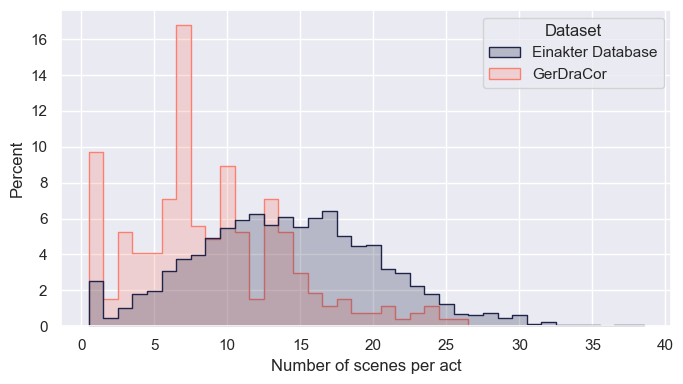

In [10]:
# Create histplot of scenes_per_act per dataset
plot_data = (
    einakter_and_gerdracor_q2.drop_nulls("scenes_per_act")
    .sort("Dataset")
    .to_pandas()
)

ax = sns.histplot(
    plot_data,
    x="scenes_per_act",
    hue="Dataset",
    stat="percent",
    multiple="layer",
    element="step",
    common_norm=False,  # Normalise each dataset separately
    discrete=True,
    palette=[dracor_blue, "salmon"],
)
plt.xlabel("Number of scenes per act")
plt.savefig("plots/gerdracor_scenes.png", dpi=dpi)
plt.show()

## Q3 Number of characters

Is there a difference in the number of characters between German one-act plays and other German plays of the same period?


In [11]:
# Check characters_n for normality per Dataset

(
    einakter_and_gerdracor.group_by("Dataset").map_groups(
        lambda df: shapiro_wilk(df["characters_n"].drop_nulls()) and df
    )
)

Shapiro-Wilk Test: W=0.8773241669045071, p=4.718917680317186e-40
The data is not normally distributed.
Shapiro-Wilk Test: W=0.6040347245673656, p=1.834771485359684e-24
The data is not normally distributed.


id,acts_n,scenes_n,characters_n,year_norm,Dataset
str,i64,i64,i64,i64,str
"""ein000001""",1,22,6,1842,"""Einakter Datab…"
"""ein000002""",1,17,7,1818,"""Einakter Datab…"
"""ein000003""",1,6,2,1821,"""Einakter Datab…"
"""ein000004""",1,14,5,1821,"""Einakter Datab…"
"""ein000005""",1,12,5,1819,"""Einakter Datab…"
…,…,…,…,…,…
"""ger000295""",4,39,26,1828,"""GerDraCor"""
"""ger000607""",3,24,6,1836,"""GerDraCor"""
"""ger000505""",2,9,7,1835,"""GerDraCor"""


In [12]:
characters_n_agg = (
    einakter_and_gerdracor.drop_nulls("characters_n")
    .group_by("Dataset", "acts_n")
    .agg(
        pl.len().alias("plays"),
        pl.mean("characters_n").name.suffix("_mean"),
        # Calculate bootstrapped confidence intervals
        ci=pl.col("characters_n").map_elements(
            lambda x: stats.bootstrap(
                (x,),
                np.mean,
                confidence_level=confidence_level,
                n_resamples=10_000,
                method="BCa",
                random_state=42,  # For reproducibility
            ).confidence_interval,
        ),
    )
    .sort("acts_n")
)

characters_n_agg

Dataset,acts_n,plays,characters_n_mean,ci
str,i64,u32,f64,list[f64]
"""Einakter Datab…",1,2416,7.059189,"[6.940204, 7.186258]"
"""GerDraCor""",2,32,20.15625,"[15.8125, 25.4375]"
"""GerDraCor""",3,70,19.571429,"[16.614286, 23.76935]"
"""GerDraCor""",4,28,21.428571,"[17.428571, 33.520329]"
"""GerDraCor""",5,140,28.492857,"[24.311344, 35.247793]"


In [13]:
to_latex(
    characters_n_agg.select(
        "Dataset",
        pl.col("acts_n").alias("Number of acts"),
        pl.col("plays").alias("n"),
        pl.col("characters_n_mean").alias("Mean number of characters"),
        "ci",
    ),
    caption="Mean number of characters per play across Einakter Database and GerDraCor datasets with bootstrapped confidence intervals.",
    label="tab:characters_gerdracor",
)

Saved to latex/characters_gerdracor.tex


In [14]:
# Conduct a Mann-Whitney U test to compare the distributions of characters per play across the datasets (pairwise)

groups_dict = einakter_and_gerdracor.sort("acts_n").drop_nulls("characters_n").partition_by(
    ["acts_n"], as_dict=True
)

q3_mann_whitney = pl.DataFrame()
for i in groups_dict.keys():
    einakter_sample = groups_dict[1,]["characters_n"]
    comparison_sample = groups_dict[i]["characters_n"]
    print("acts_n = 1 vs acts_n =", i)
    result = mann_whitney(einakter_sample, comparison_sample)
    q3_mann_whitney = q3_mann_whitney.vstack(
        pl.DataFrame(
            {
                "acts_n": [i[0]],
                "statistic": [result.statistic],
                "pvalue": [result.pvalue],
            }
        )
    )

# Add significance markers
q3_mann_whitney = q3_mann_whitney.with_columns(
    sig=pl.col("pvalue").map_elements(lambda p: "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns")
)
q3_mann_whitney

acts_n = 1 vs acts_n = (1,)
Mann-Whitney U Test: H=2918528.0, p=1.0
There is no significant difference between the samples.
acts_n = 1 vs acts_n = (2,)
Mann-Whitney U Test: H=12813.5, p=5.476618577198213e-11
There is a significant difference between the samples.
acts_n = 1 vs acts_n = (3,)
Mann-Whitney U Test: H=18434.5, p=2.1974408109949757e-29
There is a significant difference between the samples.
acts_n = 1 vs acts_n = (4,)
Mann-Whitney U Test: H=3343.5, p=1.2871449261369064e-16
There is a significant difference between the samples.
acts_n = 1 vs acts_n = (5,)
Mann-Whitney U Test: H=28585.5, p=2.1382951176560105e-62
There is a significant difference between the samples.


acts_n,statistic,pvalue,sig
i64,f64,f64,str
1,2.918528e6,1.0,"""ns"""
2,12813.5,5.4766e-11,"""***"""
3,18434.5,2.1974e-29,"""***"""
4,3343.5,1.2871e-16,"""***"""
5,28585.5,2.1383e-62,"""***"""


In [15]:
q3_results_with_mann_whitney = characters_n_agg.join(
    q3_mann_whitney, on="acts_n", how="left"
).filter(pl.col("Dataset") == "GerDraCor") # Use only GerDraCor for the table

to_latex(
    q3_results_with_mann_whitney.select(
        "Dataset",
        pl.col("acts_n").alias("Number of acts"),
        pl.col("statistic").alias("$U$"),
        pl.col("sig").alias(""),
    ),
    caption="Mann-Whitney U test results comparing the number of characters between the Einakter Database and GerDraCor datasets. Significance levels: * $p < 0.05$, ** $p < 0.01$, *** $p < 0.001$, ns $p \geq 0.05$.",
    label="tab:characters_gerdracor_mann_whitney",
    na_rep="",
)

Saved to latex/characters_gerdracor_mann_whitney.tex


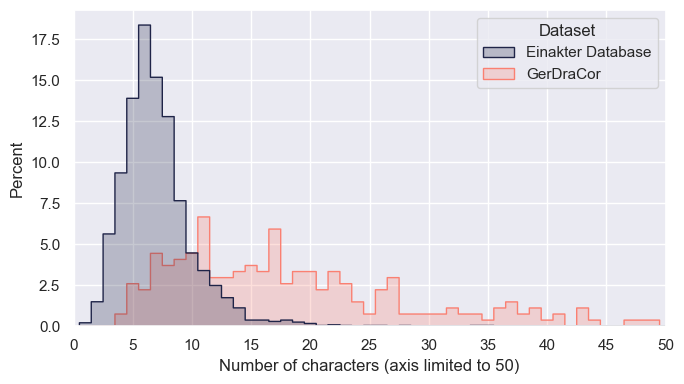

In [16]:
# Create histplot of characters_n per dataset
plot_data = (
    einakter_and_gerdracor.drop_nulls("characters_n")
    .rename(
        # Make labels friendlier
        {
            "acts_n": "Number of acts",
        }
    )
    .sort("Dataset")
    .to_pandas()
)

ax = sns.histplot(
    plot_data,
    x="characters_n",
    hue="Dataset",
    stat="percent",
    multiple="layer",
    element="step",
    common_norm=False,  # Normalise each dataset separately
    discrete=True,
    palette=[dracor_blue, "salmon"],
)
max_x = 50
# plt.title("Distribution of number of characters in the Einakter Database and GerDraCor")
plt.xlabel(f"Number of characters (axis limited to {max_x})")
ax.set_xlim(
    0, max_x
)  # We do this as an axis limit, not a filter in order not to distort relative stats, e.g. percent or density
ax.set_xticks(range(0, max_x + 1, 5))

plt.savefig("plots/gerdracor_characters.png", dpi=dpi)
plt.show()

## Q3a Pazarkaya’s sample

Did Pazarkaya’s sample give a representative picture of the number of characters in German one-act plays of the period under investigation?

In [17]:
# Initialise Pazarkaya data
pazarkaya = (
    pl.DataFrame(
        {
            "numberOfCharacters": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
            "count": [2, 21, 28, 41, 44, 30, 27, 17, 5, 1, 2, 2, 1],
        }
    )
    .select(
        # Convert to long format for plotting
        pl.col("numberOfCharacters").repeat_by("count")
    )
    .explode("numberOfCharacters")
)

# Add both to common dataframe with "Dataset" column
einakter_pazarkaya_characters = (
    pl.concat(
        [
            einakter.select("numberOfCharacters").with_columns(
                Dataset=pl.lit("Einakter Database")
            ),
            pazarkaya.select("numberOfCharacters").with_columns(
                Dataset=pl.lit("Pazarkaya")
            ),
        ],
        how="vertical_relaxed",
    )
    .drop_nulls("numberOfCharacters")
    .with_columns(n=pl.len().over("Dataset"))
)
einakter_pazarkaya_characters

numberOfCharacters,Dataset,n
i64,str,u32
6,"""Einakter Datab…",2416
7,"""Einakter Datab…",2416
2,"""Einakter Datab…",2416
5,"""Einakter Datab…",2416
5,"""Einakter Datab…",2416
…,…,…
12,"""Pazarkaya""",221
12,"""Pazarkaya""",221
13,"""Pazarkaya""",221


In [18]:
# Calculate confidence intervals per dataset
characters_n_q3a = (
    einakter_pazarkaya_characters
    .group_by("Dataset")
    .agg(
        pl.len().alias("n"),
        pl.mean("numberOfCharacters").name.suffix("_mean"),
        # Calculate bootstrapped confidence intervals
        ci=pl.col("numberOfCharacters").map_elements(
            lambda x: stats.bootstrap(
                (x,),
                np.mean,
                confidence_level=confidence_level,
                n_resamples=10_000,
                method="BCa",
                random_state=42,  # For reproducibility
            ).confidence_interval,
        ),
    )
)
characters_n_q3a

Dataset,n,numberOfCharacters_mean,ci
str,u32,f64,list[f64]
"""Pazarkaya""",221,6.117647,"[5.850679, 6.411765]"
"""Einakter Datab…",2416,7.059189,"[6.940204, 7.186258]"


In [19]:
to_latex(
    characters_n_q3a.select(
        "Dataset",
        pl.col("n"),
        pl.col("numberOfCharacters_mean").alias("Mean number of characters"),
        "ci",
    ).sort("Dataset"),
    caption="Mean number of characters per play in Einakter Database and Pazarkaya’s samples with bootstrapped confidence intervals.",
    label="tab:characters_pazarkaya",
)

Saved to latex/characters_pazarkaya.tex


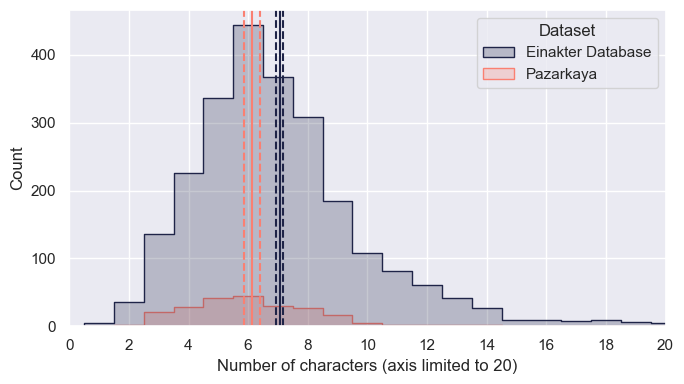

In [20]:
# Histogram
max_x = 20
ax = sns.histplot(
    einakter_pazarkaya_characters,
    x="numberOfCharacters",
    stat="count",
    common_norm=False,  # Normalise each dataset separately
    discrete=True,
    hue="Dataset",
    element="step",
    multiple="layer",
    palette=[dracor_blue, "salmon"],
    hue_order=einakter_pazarkaya_characters.get_column("Dataset").unique().sort(),
)
plt.xlabel(f"Number of characters (axis limited to {max_x})")
ax.set_xlim(
    0, max_x
)  # We do this as an axis limit, not a filter in order not to distort relative stats, e.g. percent or density
ax.set_xticks(range(0, max_x + 1, 2))

# Add confidence intervals
for dataset in einakter_pazarkaya_characters.get_column("Dataset").unique().sort():
    # Add mean 
    plt.axvline(
        characters_n_q3a.filter(pl.col("Dataset") == dataset)["numberOfCharacters_mean"][0],
        color=dracor_blue if dataset == "Einakter Database" else "salmon",
        linestyle="-",
    )
    # Add CIs
    ci_low, ci_high = characters_n_q3a.filter(pl.col("Dataset") == dataset)["ci"][0]
    for ci in [ci_low, ci_high]:
        plt.axvline(ci, color=dracor_blue if dataset == "Einakter Database" else "salmon", linestyle="--")

plt.savefig("plots/pazarkaya_characters.png", dpi=dpi)
plt.show()

In [21]:
# Calculate Mann-Whitney U test for the number of characters per play between the Einakter Database and Pazarkaya’s sample

groups_dict = einakter_pazarkaya_characters.sort("Dataset").partition_by(
    ["Dataset"], as_dict=True
)

# Do this for each pairing: acts_n==1 vs acts_n==[2,3,4,5]
einakter_chars = groups_dict["Einakter Database",]["numberOfCharacters"]
pazarkaya_chars = groups_dict["Pazarkaya",]["numberOfCharacters"]
result = mann_whitney(einakter_chars, pazarkaya_chars)
pazarkaya_mann_whitney = pl.DataFrame(
    {
        "statistic": [result.statistic],
        "pvalue": [result.pvalue],
    }
).with_columns(
# Add significance markers
    sig=pl.col("pvalue").map_elements(
        lambda p: (
            "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        )
    )
)
pazarkaya_mann_whitney

Mann-Whitney U Test: H=313403.5, p=1.5485910008555e-05
There is a significant difference between the samples.


statistic,pvalue,sig
f64,f64,str
313403.5,0.000015,"""***"""


## Q4 Translations

From which languages do one-act playwrights translate the most?


In [22]:
# Use basedOn column
originals = (
    einakter["basedOn"]
    .drop_nulls()  # Drop empty values
    .explode()
    .struct.unnest()
    .drop_nulls("id")  # Drop originals without an id (these are string-only values)
)

language_mapping = {
    "cze": "Czech",
    "dan": "Danish",
    "dut": "Dutch",
    "eng": "English",
    "fre": "French",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
    "spa": "Spanish",
}

originals_languages_agg = (
    originals.select(pl.col("language").value_counts(sort=True))
    .unnest("language")
    .with_columns(
        percent=pl.col("count") / pl.col("count").sum() * 100,
        language_label=pl.col("language").replace(language_mapping),
    )
)


originals_languages_agg = originals_languages_agg.with_columns(
    # Calculate binomial CI
    ci=pl.col("count")
    .map_elements(
        lambda k: stats.binomtest(k, originals.height).proportion_ci(
            confidence_level, method="exact"  # Use Clopper-Pearson method
        ),
        return_dtype=pl.List(pl.Float64),
    )
    .list.eval((pl.element() * 100).round_sig_figs(3))
)

originals_languages_agg

language,count,percent,language_label,ci
str,u32,f64,str,list[f64]
"""fre""",626,91.923642,"""French""","[89.6, 93.9]"
"""ita""",16,2.349486,"""Italian""","[1.35, 3.79]"
"""dan""",15,2.202643,"""Danish""","[1.24, 3.61]"
"""eng""",9,1.321586,"""English""","[0.606, 2.49]"
"""spa""",6,0.881057,"""Spanish""","[0.324, 1.91]"
"""dut""",3,0.440529,"""Dutch""","[0.0909, 1.28]"
"""lat""",3,0.440529,"""Latin""","[0.0909, 1.28]"
"""rus""",2,0.293686,"""Russian""","[0.0356, 1.06]"
"""cze""",1,0.146843,"""Czech""","[0.00372, 0.815]"


In [23]:
to_latex(
    originals_languages_agg.select(
        pl.col("language_label").alias("Language"),
        pl.col("count").alias("n"),
        pl.col("percent").alias("Percent"),
        "ci",
    ),
    caption="Proportion of original languages of translated plays with binomial confidence intervals.",
    label="tab:originals_languages",
)

Saved to latex/originals_languages.tex


/nix/store/awsv0164k2zdf2m49knc8rj0w9dz9n9b-python3-3.11.9-env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/nix/store/awsv0164k2zdf2m49knc8rj0w9dz9n9b-python3-3.11.9-env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/nix/store/awsv0164k2zdf2m49knc8rj0w9dz9n9b-python3-3.11.9-env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/nix/store/awsv0164k2zdf2m49knc8rj0w9dz9n9b-python3-3.11.9-env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight 

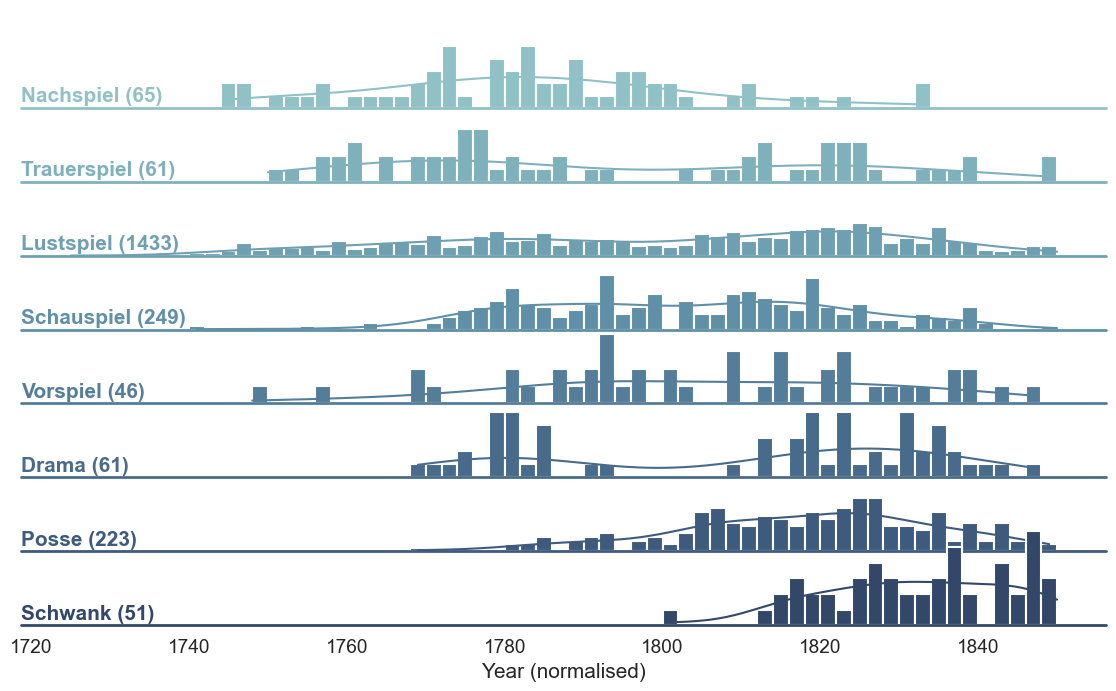

In [24]:
# Ridge plot (overlapping histograms)

import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.25)

# Sort entries by mean year within category
subtitles_by_mean_year = subtitles.with_columns(
    mean_year=pl.col("normalizedYear").mean().over(pl.col("category")),
    category_label=pl.col("category") + " (" + pl.len().over("category").cast(pl.Utf8) + ")",
).sort("mean_year")

pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
g = sns.FacetGrid(
    subtitles_by_mean_year.to_pandas(),
    row="category_label",
    hue="category_label",
    aspect=15,
    height=0.5,
    palette=pal,
)

# Draw histplot
g.map(
    sns.histplot,
    "normalizedYear",
    binwidth=2,
    binrange=(1740, 1850),  # Use the same range for all plots
    stat="proportion",  # So bar heights sum to 1
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
    kde=True,
)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.12,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label, "normalizedYear")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Set x-axis label
plt.xlabel("Year (normalised)")

# Set figure size
fig = plt.gcf()
fig.set_size_inches(14, 8)

plt.savefig("plots/ridgeplot.png", dpi=dpi)